# Uncertainty in Computer Vision

## Cross Entropy Loss + Softmax Baseline

This notebook contains an implementation of the baseline uncertainty estimation model - a simple convolutional neural network (LeNet), trained wrt cross entropy loss. The output vector, scaled by a softmax function indicates the confidence values of each output class.

**This notebook is meant for demonstration purposes and does not include optimal training parameters**

_Author: Domantas Giržadas, 2022_

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

# For SSL certificate error during dataset download
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Setting up the cuda device for performing computations on a GPU
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
    print(f"Current device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print(f"Current device: CPU")

Current device: NVIDIA GeForce RTX 3080


In [4]:
# Initialising the dataset loaders for training and test sets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
def imshow(img):
    """
    Function for visualising the images from the CIFAR-10 dataset
    """
    img = img / 2 + 0.5     # (unnormalizing)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

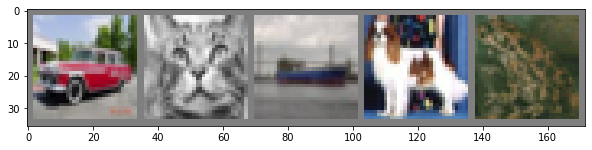

          car           cat          ship           dog          frog


In [5]:
# Getting a batch of images from the dataset and visualising them
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))
# Print image labels
print(' '.join('%13s' % classes[labels[j]] for j in range(len(images))))

# Basic Neural Network with Cross Entropy

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Initialising the CNN
class LeNet_base(nn.Module):
    def __init__(self):
        super(LeNet_base, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = LeNet_base()
net.to(device)

LeNet_base(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Training

In [48]:
# Initialising the training parameters
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

max_iteration = len(trainloader) * 20
lambda_poly = lambda iteration: pow((1.0 - iteration / max_iteration), 0.9)

optimizer = optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_poly)

In [49]:
# Model training
for epoch in range(20):  # loop over the dataset 20 times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.814
[1,  4000] loss: 1.543
[1,  6000] loss: 1.447
[1,  8000] loss: 1.392
[1, 10000] loss: 1.344
[2,  2000] loss: 1.263
[2,  4000] loss: 1.231
[2,  6000] loss: 1.235
[2,  8000] loss: 1.198
[2, 10000] loss: 1.207
[3,  2000] loss: 1.135
[3,  4000] loss: 1.125
[3,  6000] loss: 1.103
[3,  8000] loss: 1.116
[3, 10000] loss: 1.095
[4,  2000] loss: 1.042
[4,  4000] loss: 1.028
[4,  6000] loss: 1.058
[4,  8000] loss: 1.028
[4, 10000] loss: 1.034
[5,  2000] loss: 0.977
[5,  4000] loss: 0.972
[5,  6000] loss: 0.996
[5,  8000] loss: 0.976
[5, 10000] loss: 0.979
[6,  2000] loss: 0.903
[6,  4000] loss: 0.923
[6,  6000] loss: 0.932
[6,  8000] loss: 0.943
[6, 10000] loss: 0.938
[7,  2000] loss: 0.859
[7,  4000] loss: 0.867
[7,  6000] loss: 0.873
[7,  8000] loss: 0.908
[7, 10000] loss: 0.890
[8,  2000] loss: 0.799
[8,  4000] loss: 0.846
[8,  6000] loss: 0.838
[8,  8000] loss: 0.854
[8, 10000] loss: 0.850
[9,  2000] loss: 0.775
[9,  4000] loss: 0.797
[9,  6000] loss: 0.816
[9,  8000] 

In [50]:
# Optionally, save the model to a .pt file
torch.save(net, "model-baseline.pt")

## Evaluation

In [15]:
net = torch.load("model-baseline.pt")

In [17]:
# Evaluate training and validation accuracy

train_hits = []
test_hits = []

for i, data in enumerate(trainloader):
    print(f"Training set... \t{i+1} / {len(trainloader)}", end = '\r')
    inputs, labels = data
    inputs = inputs.to(device)
    pred_base = F.softmax(net(inputs)).cpu().detach().numpy()

    train_hits.extend(np.array(np.argmax(pred_base, axis = 1)) == np.array(labels))
    
print("                               ",end='\r')

for i, data in enumerate(testloader):
    print(f"Validation set... \t{i+1} / {len(testloader)}\t", end = '\r')
    inputs, labels = data
    inputs = inputs.to(device)
    pred_base = F.softmax(net(inputs)).cpu().detach().numpy()

    test_hits.extend(np.array(np.argmax(pred_base, axis = 1)) == np.array(labels))
    
print("                               ",end='\r')
print(f"Training accuracy: {np.mean(train_hits)*100:.3f}%")
print(f"Validation accuracy: {np.mean(test_hits)*100:.3f}%")

<ipython-input-17-1abe593c1b9d>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_base = F.softmax(net(inputs)).cpu().detach().numpy()


<ipython-input-17-1abe593c1b9d>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_base = F.softmax(net(inputs)).cpu().detach().numpy()


Training accuracy: 86.758%     
Validation accuracy: 64.760%


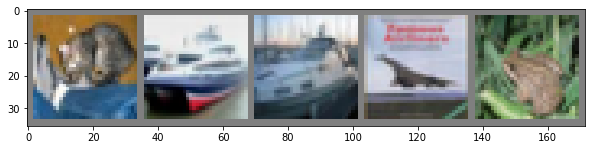

          cat          ship          ship         plane          frog


<ipython-input-18-64715646eb0e>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  net_outputs = F.softmax(net(images)).cpu().detach().numpy()


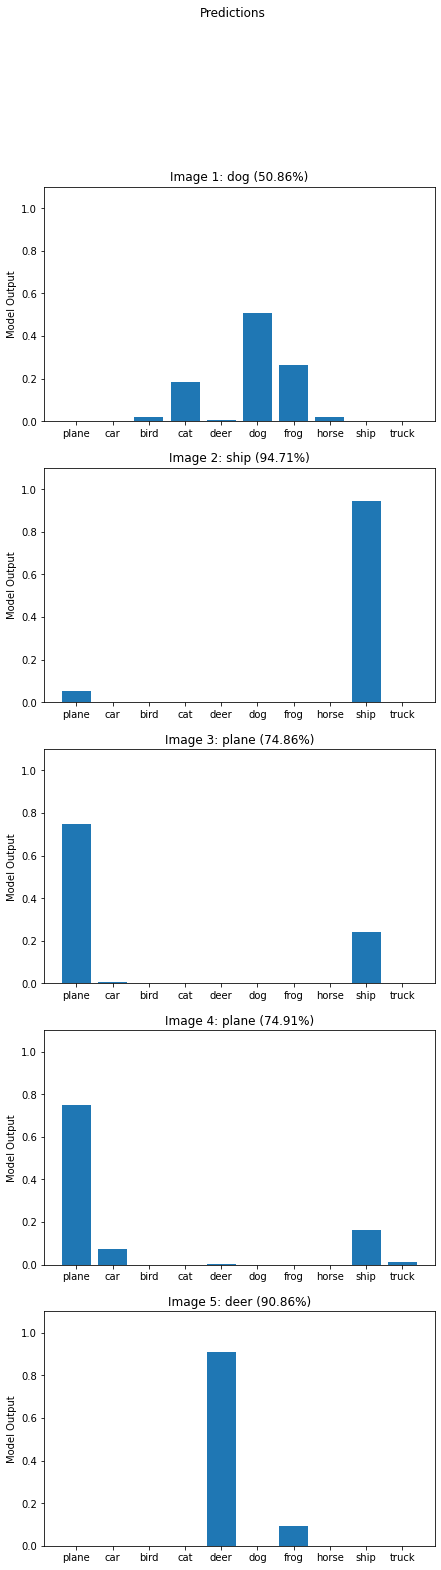

In [18]:
# Predict a batch of validation images and visualise the model output
dataiter = iter(testloader)

images, labels = dataiter.next()
plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%13s' % classes[labels[j]] for j in range(len(images))))

images = images.to(device)
net_outputs = F.softmax(net(images)).cpu().detach().numpy()

fig, axs = plt.subplots(len(images), 1, figsize=(7,25))
plt.setp(axs, xticks=np.arange(10), xticklabels=classes, ylim=(0,1.1), ylabel="Model Output")
fig.suptitle('Predictions')

for i in range(len(images)):
    axs[i].bar(np.arange(10), np.array(net_outputs[i]))
    axs[i].set_title(f"Image {i+1}: {classes[np.argmax(net_outputs[i])]} ({net_outputs[i].max()*100:.2f}%)")
plt.show()